Dataset: https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview

In [5]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_log_error , mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [6]:
train = pd.read_csv('train.csv')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [9]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [10]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [11]:
train.duplicated().sum()

0

## EDA

### Vender ID

In [12]:
train['vendor_id'].unique()

array([2, 1])

<AxesSubplot:xlabel='vendor_id', ylabel='count'>

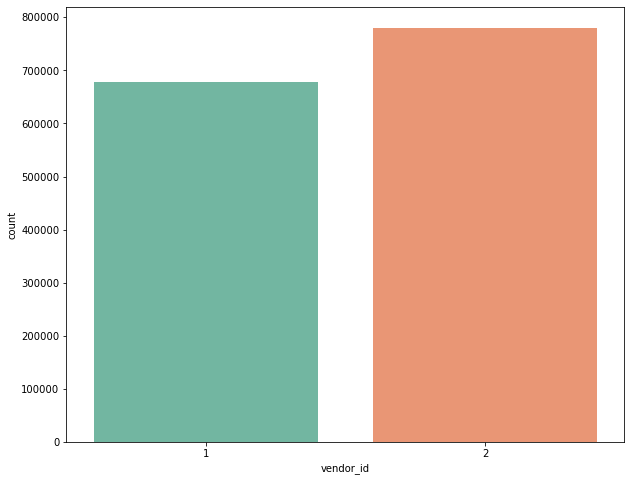

In [13]:
plt.figure(figsize=(10,8))
sns.countplot(train['vendor_id'], palette='Set2')

### Passenger Count

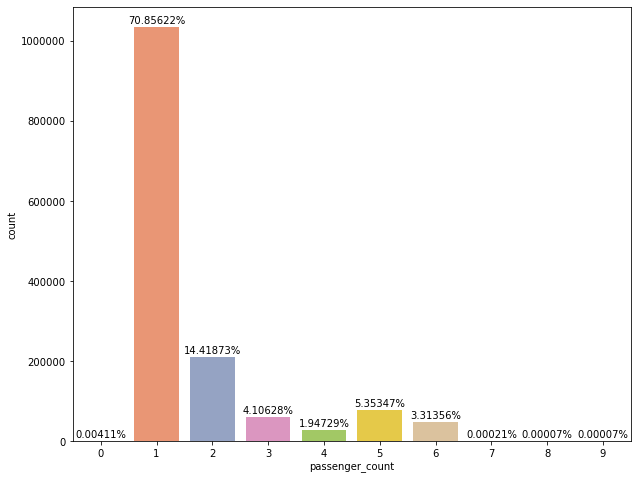

In [14]:
plt.figure(figsize=(10,8))
sns.countplot(train['passenger_count'], palette='Set2')
plt.ticklabel_format(style='plain', axis = 'y')

count = train['passenger_count'].value_counts()

for i in range(len(count)):
    percentage = '{:1.5f}%'.format(count[i]/train.shape[0] * 100)
    plt.text(i, count[i] + 10000, percentage, ha = 'center')

There are 0.00411% trips have 0 passenger.

### Store and Fwd Flag

In [15]:
flag = train['store_and_fwd_flag'].unique()

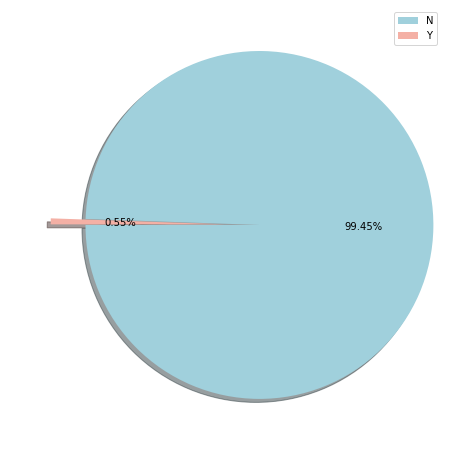

In [16]:
plt.figure(figsize=(8,8))
plt.pie(train['store_and_fwd_flag'].value_counts(), colors = ['#a0d0dc','#f4b0a5'], startangle = 180, explode = [0.2,0], autopct='%1.2f%%', shadow = True)
plt.legend(flag)

### Trip Duration

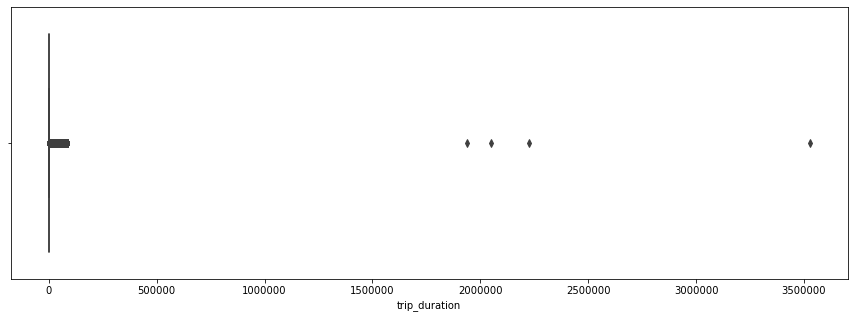

In [17]:
plt.figure(figsize=(15,5))
sns.boxplot(train['trip_duration'])
plt.ticklabel_format(style='plain', axis = 'x')

There are 4 outlier which duration is more than 1900000s (528h).
For the evaluation metric RMSLE, we could logtransform trip duration.

<AxesSubplot:xlabel='log_trip_duration'>

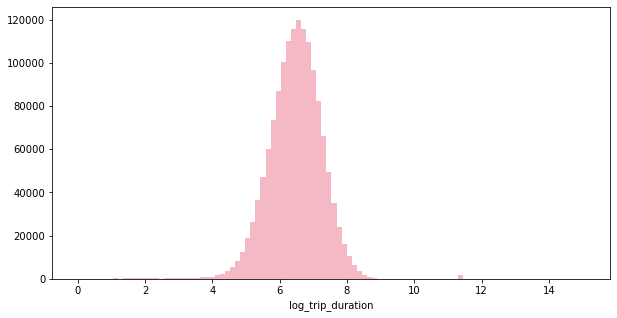

In [18]:
train['log_trip_duration'] = np.log(train['trip_duration'])
plt.figure(figsize=(10,5))
sns.distplot(train['log_trip_duration'], bins = 100, color='#e85070', kde = False)

In [19]:
train = train[train['trip_duration']< 1500000]

### Pickup and Dropoff Location Map

The borders of NYC

city_long_border = (-74.03, -73.75) 

city_lat_border = (40.63, 40.85)


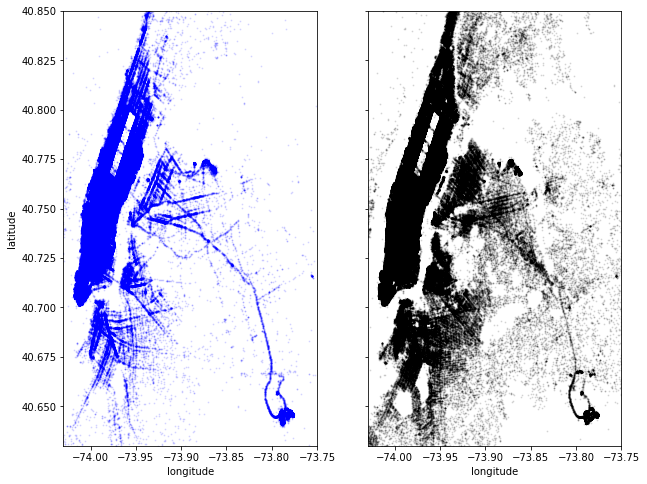

In [20]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(figsize = (10,8), ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values, train['pickup_latitude'].values, color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(train['dropoff_longitude'].values, train['dropoff_latitude'].values, color='black', s=1, label='train', alpha=0.1)

ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [21]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85
train = train[(train.pickup_latitude> south) & (train.pickup_latitude < north)]
train = train[(train.dropoff_latitude> south) & (train.dropoff_latitude < north)]
train = train[(train.pickup_longitude> west) & (train.pickup_longitude < east)]
train = train[(train.dropoff_longitude> west) & (train.dropoff_longitude < east)]

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1438622 entries, 0 to 1458643
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1438622 non-null  object 
 1   vendor_id           1438622 non-null  int64  
 2   pickup_datetime     1438622 non-null  object 
 3   dropoff_datetime    1438622 non-null  object 
 4   passenger_count     1438622 non-null  int64  
 5   pickup_longitude    1438622 non-null  float64
 6   pickup_latitude     1438622 non-null  float64
 7   dropoff_longitude   1438622 non-null  float64
 8   dropoff_latitude    1438622 non-null  float64
 9   store_and_fwd_flag  1438622 non-null  object 
 10  trip_duration       1438622 non-null  int64  
 11  log_trip_duration   1438622 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 142.7+ MB


## Feature Engineering

In [23]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_min'] = train['pickup_datetime'].dt.minute
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday

<AxesSubplot:xlabel='pickup_month', ylabel='count'>

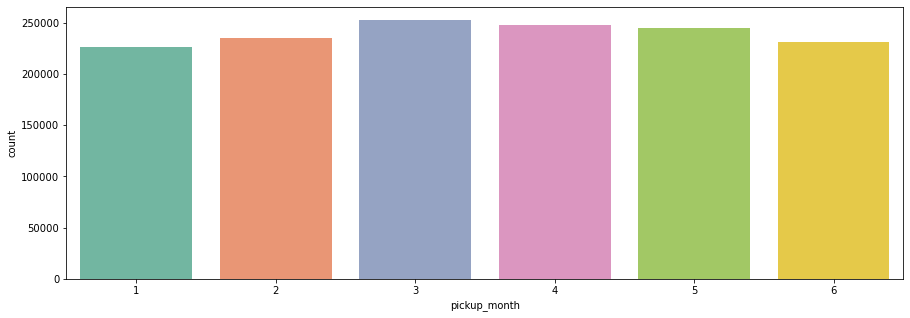

In [24]:
plt.figure(figsize=(15,5))
sns.countplot(train['pickup_month'], palette='Set2')

Text(0.5, 0, 'Pickup_Day')

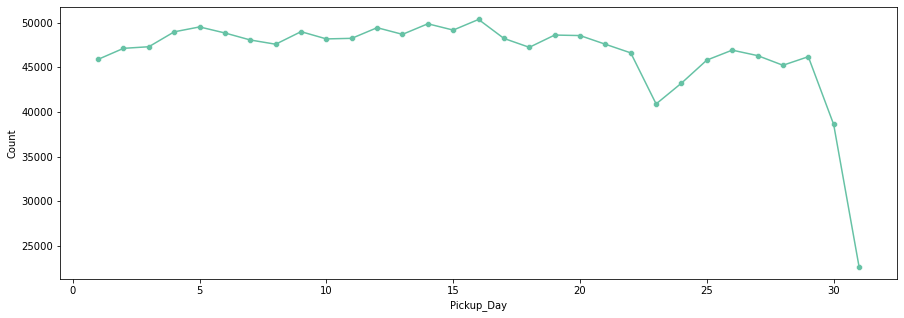

In [25]:
plt.figure(figsize=(15,5))
sns.scatterplot(x = train['pickup_day'].value_counts().index, y = train['pickup_day'].value_counts(), color = '#66c2a5')
sns.lineplot(x = train['pickup_day'].value_counts().index, y = train['pickup_day'].value_counts(), color = '#66c2a5')
plt.ylabel('Count')
plt.xlabel('Pickup_Day')

Text(0.5, 0, 'Pickup_Hour')

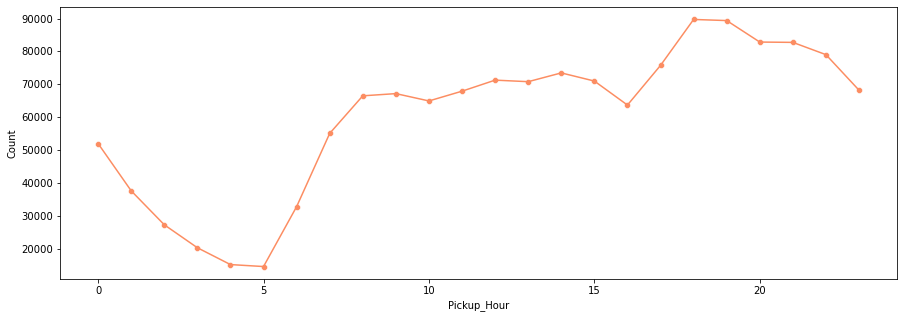

In [26]:
plt.figure(figsize=(15,5))
sns.scatterplot(x = train['pickup_hour'].value_counts().index, y = train['pickup_hour'].value_counts(), color = '#fc8d62')
sns.lineplot(x = train['pickup_hour'].value_counts().index, y = train['pickup_hour'].value_counts(), color = '#fc8d62')
plt.ylabel('Count')
plt.xlabel('Pickup_Hour')

Text(0.5, 0, 'Pickup_Min')

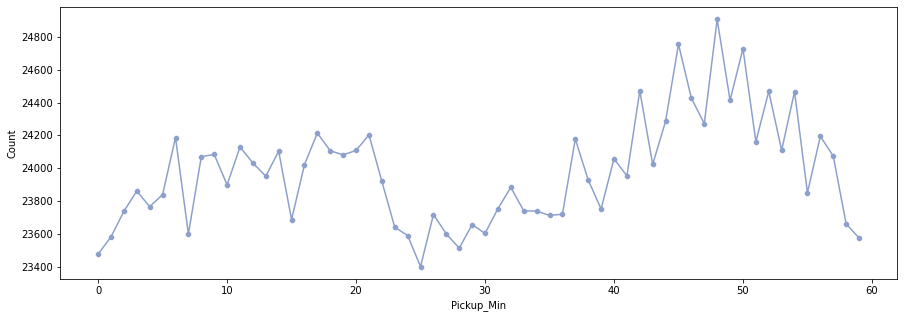

In [27]:
plt.figure(figsize=(15,5))
sns.scatterplot(x = train['pickup_min'].value_counts().index, y = train['pickup_min'].value_counts(), color = '#8da0cb')
sns.lineplot(x = train['pickup_min'].value_counts().index, y = train['pickup_min'].value_counts(), color = '#8da0cb')
plt.ylabel('Count')
plt.xlabel('Pickup_Min')

([<matplotlib.axis.XTick at 0x7fdc9a6478e0>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

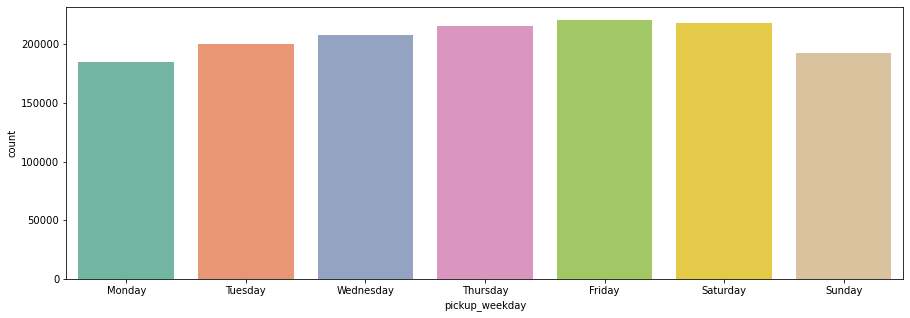

In [28]:
plt.figure(figsize=(15,5))
sns.countplot(train['pickup_weekday'], palette='Set2')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

<AxesSubplot:>

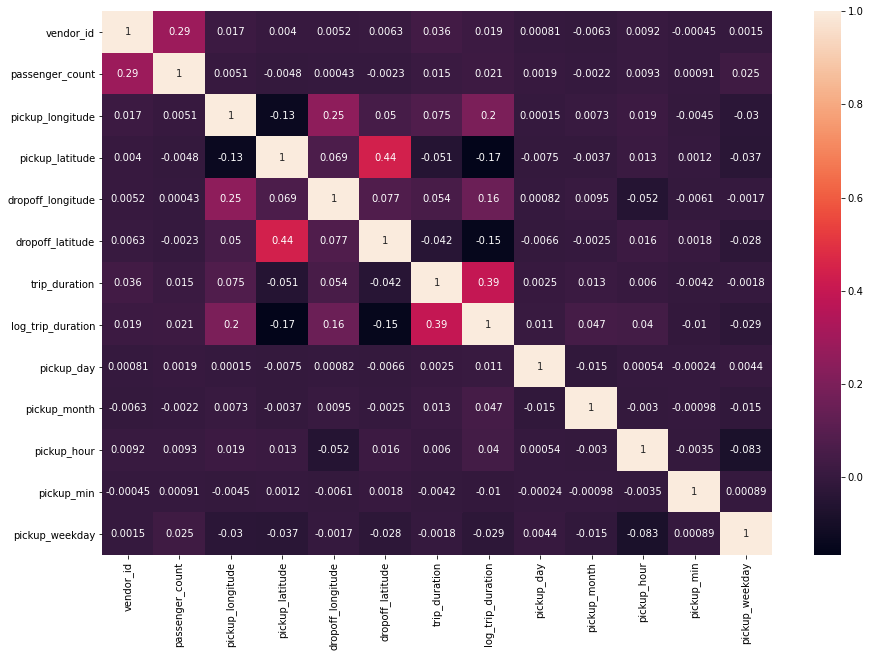

In [29]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot = True)

### Label Encoding

In [30]:
lbl = LabelEncoder()
train['store_and_fwd_flag'] = lbl.fit_transform(train['store_and_fwd_flag'])
train['vendor_id'] = lbl.fit_transform(train['vendor_id'])

In [31]:
train = train.drop(['id','pickup_datetime','pickup_date','dropoff_datetime'], axis = 1)

In [32]:
train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_weekday
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,6.120297,14,3,17,24,0
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6.496775,12,6,0,43,6
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,7.661056,19,1,11,35,1
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6.061457,6,4,19,32,2
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,435,6.075346,26,3,13,30,5


### Scaling Data

In [33]:
X = train.drop(['trip_duration','log_trip_duration'], axis = 1)
y = train['log_trip_duration']

In [34]:
scaler = StandardScaler()
Scaled_X = scaler.fit_transform(X)

In [35]:
Scaled_X

array([[ 0.93243901, -0.50559679, -0.2238746 , ...,  0.53048405,
        -0.32268222, -1.56071034],
       [-1.07245621, -0.50559679, -0.17697255, ..., -2.13442126,
         0.7739703 ,  1.51060563],
       [ 0.93243901, -0.50559679, -0.13953319, ..., -0.41007077,
         0.31222187, -1.04882435],
       ...,
       [ 0.93243901, -0.50559679,  0.39696045, ..., -1.19386645,
         1.58203005,  0.48683364],
       [-1.07245621, -0.50559679, -0.22181749, ...,  0.21696577,
         1.52431149, -1.04882435],
       [-1.07245621, -0.50559679, -0.15331581, ...,  0.06020664,
         0.83168885, -1.04882435]])

### PCA

In [36]:
pca = PCA(n_components=12)
principal_components = pca.fit_transform(Scaled_X)

## Modelling

In [37]:
X = principal_components
y = train['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1007035, 12), (431587, 12), (1007035,), (431587,))

### LinearRegression

In [35]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [36]:
lr_pred = model_lr.predict(X_test)
lr_pred

array([6.33142494, 6.30902818, 6.35774767, ..., 6.78160912, 6.46033273,
       6.3760651 ])

In [40]:
print ("Training Score : " , model_lr.score(X_train, y_train))
print ("RMSLE : ", np.sqrt(mean_squared_log_error(lr_pred, y_test)))

Training Score :  0.09494494775071027
RMSLE :  0.10969473483090741


### DecisionTree

In [42]:
model_dt = DecisionTreeRegressor(criterion="friedman_mse", max_depth=10)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10)

In [43]:
dt_pred = model_dt.predict(X_test)
dt_pred

array([6.38123595, 6.05938459, 6.38123595, ..., 7.0084043 , 5.97588294,
       7.03875793])

In [44]:
print ("Training Score : " , model_dt.score(X_train, y_train))
print ("RMSLE : ", np.sqrt(mean_squared_log_error(dt_pred, y_test)))

Training Score :  0.5137030157812159
RMSLE :  0.08380898495653892


### RandomForest

In [46]:
model_rf = RandomForestRegressor(criterion="friedman_mse", n_estimators=5, max_depth=10)
model_rf.fit(X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', max_depth=10, n_estimators=5)

In [47]:
rf_pred = model_rf.predict(X_test)
rf_pred

array([6.39314381, 6.07466235, 6.39314381, ..., 7.06382707, 5.96468101,
       7.04816511])

In [49]:
print ("Training Score : " , model_rf.score(X_train, y_train))
print ("RMSLE : ", np.sqrt(mean_squared_log_error(rf_pred, y_test)))

Training Score :  0.5319423588649825
RMSLE :  0.08219518447945227


### XGBoost

In [43]:
from xgboost.sklearn import XGBRegressor

In [44]:
xgb_model = XGBRegressor(objective='reg:linear', n_estimators=150, subsample=0.75)
xgb_model.fit(X_train,y_train)

[13:53:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [46]:
xgb_pred = xgb_model.predict(X_test)
xgb_pred

array([6.3334966, 5.7331624, 6.2834644, ..., 7.1997447, 6.204525 ,
       7.014935 ], dtype=float32)

In [47]:
print ("Training Score : " , xgb_model.score(X_train, y_train))
print ("RMSLE : ", np.sqrt(mean_squared_log_error(xgb_pred, y_test)))

Training Score :  0.6896130957142637
RMSLE :  0.06946571158038911
